In [1]:
from google.cloud import bigquery
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D
import upsetplot
from sankeyflow import Sankey
import sklearn

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [3]:
client = bigquery.Client(project='subugoe-collaborative')

In [5]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [6]:
openalex = 'subugoe-collaborative.openalex'
s2 = 'subugoe-wag-closed.S2AG'
pm = 'subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022'
cr = 'subugoe-collaborative.cr_instant.snapshot'

In [7]:
openalex_type_mapping = {
    'journal': {
        'editorial_discourse': ['erratum', 'editorial', 'letter', 'paratext'],
        'research_discourse': ['article']
    }
}

In [8]:
s2_type_mapping = {
    'journal': {
        'editorial_discourse': ['Editorial', 'News', 'LettersAndComments'],
        'research_discourse': ['Review', 'MetaAnalysis', 'JournalArticle', 'Study', 'CaseReport', 'ClinicalTrial']
    }
}

In [9]:
pubmed_type_mapping = {
    'journal': {
        'editorial_discourse': ['Published Erratum', 'Retraction of Publication', 'Retracted Publication', 'Editorial', 'News', 'Letter', 'Comment',
                                'Introductory Journal Article', 'Newspaper Article'],
        'research_discourse': ['Cochrane Systematic Review', 'Systematic Review', 'Meta-Analysis', 'Review', 'Case Reports', 'Randomized Controlled Trial', 'Clinical Trial', 
                               'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                               'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article', 'Comparative Study', 'Multicenter Study', 
                               'Observational Study', 'Evaluation Study', 'Historical Article', 'Validation Study', 'Clinical Study', 'Randomized Controlled Trial, Veterinary',
                               'Twin Study', 'Clinical Trial, Veterinary', 'Classical Article', 'Observational Study, Veterinary', 'Corrected and Republished Article', 
                               'Adaptive Clinical Trial', 'Evaluation Studies', 'Validation Studies', "Research Support, Non-U.S. Gov''t", "Research Support, N.I.H., Extramural", 
                               "Research Support, U.S. Gov''t, Non-P.H.S.", "Research Support, U.S. Gov''t, P.H.S.",
                               "Research Support, N.I.H., Intramural", "Research Support, American Recovery and Reinvestment Act"]
    }
}

In [10]:
crossref_type_mapping = {
    'journal': {
        'editorial_discourse': [],
        'research_discourse': ['journal-article']
    }
}

In [11]:
scp_type_mapping = {
    'journal': {
        'editorial_discourse': ['Erratum', 'Editorial', 'Letter', 'Note'],
        'research_discourse': ['Review', 'Article']
    }
}

In [12]:
wos_type_mapping = {
    'journal': {
        'editorial_discourse': ['Correction', 'Retraction', 'Retracted Publication', 'Item Withdrawal', 'Editorial Material', 'News Item', 'Letter'],
        'research_discourse': ['Review', 'Article']
    }
}

In [13]:
def mapping_types(mapping_dict, type):
    for k, v in mapping_dict.items():
        if type in v:
            return k

In [14]:
def alluvial_plot(df, db1_column_name, db2_column_name, db1_name, db2_name, image_name, width, height):
    df.fillna('None', inplace=True)
    d = {}
    for row in df.to_dict('records'):
        db1_type = row[db1_column_name] + ' (' + db1_name + ')'
        db2_type = row[db2_column_name] + ' (' + db2_name + ')'
        n = row['n']
    
        dd = {}
        dd[db2_type] = n
        
        if db1_type in d:
            d[db1_type].update(dd)
        else:
            d[db1_type] = dd

    d = {k + ' ': v for k, v in d.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [15]:
def alluvial_plot_new_types(df, db1_column_name, db2_column_name, db1_name, db2_name, db1_mapping, db2_mapping, image_name, width, height):
    df2 = df.copy()
    df2['db1_new_type'] = df2.apply(lambda row : mapping_types(db1_mapping, row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(lambda row : mapping_types(db2_mapping, row[db2_column_name]), axis=1)

    df2.fillna('None', inplace=True)

    d = {}
    for row in df2.to_dict('records'):
        db1_type = row['db1_new_type'] + ' (' + db1_name + ')'
        db2_type = row['db2_new_type'] + ' (' + db2_name + ')'
        current_r = row['db1_new_type'] + ' (' + db1_name + ')'
        n = row['n']
    
        if current_r in d:
            if db2_type in d[db1_type].keys():
                d[db1_type][db2_type] = d.get(db1_type).get(db2_type) + n
            else:
                 d[db1_type][db2_type] = n
        else:
            dd = {}
            dd[db2_type] = n
            d[db1_type] = dd

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [70]:
openalex_types = client.query(f"""
                               SELECT type AS oal_type, COUNT(DISTINCT(doi)) AS n
                               FROM {openalex}.works  
                               WHERE publication_year between 2012 AND 2022
                               GROUP BY oal_type
                               ORDER BY n DESC
                               """).to_dataframe()

In [71]:
openalex_types['prop'] = (openalex_types['n'] / openalex_types['n'].sum()) * 100
openalex_types

,oal_type,n,prop
0,article,52021682,74.123429
1,book-chapter,10390513,14.804989
2,dataset,2514037,3.582142
3,paratext,1491622,2.125347
4,book,860241,1.22572
5,other,731754,1.042644
6,dissertation,715302,1.019203
7,reference-entry,361087,0.514497
8,peer-review,340465,0.485114
9,standard,301296,0.429304


In [68]:
openalex_venues = client.query(f"""
                                SELECT s.type AS venuetype, COUNT(DISTINCT(doi)) AS n
                                FROM {openalex}.works AS w
                                LEFT JOIN {openalex}.sources AS s
                                ON primary_location.source.id = s.id
                                WHERE publication_year between 2012 AND 2022
                                GROUP BY venuetype
                                ORDER BY n DESC
                                """).to_dataframe()

In [69]:
openalex_venues['venuetype'].fillna('None', inplace=True)
openalex_venues['prop'] = (openalex_venues['n'] / openalex_venues['n'].sum()) * 100
openalex_venues

,venuetype,n,prop
0,journal,44641902,63.604126
1,None,9570035,13.635031
2,ebook platform,8736287,12.447138
3,repository,4656644,6.634614
4,book series,1741413,2.481101
5,conference,840604,1.197661
6,other,232,0.000331


In [36]:
openalex_types_venues = client.query(f"""
                                      SELECT w.type AS oal_type, s.type AS venuetype, COUNT(DISTINCT(doi)) AS n
                                      FROM {openalex}.works AS w
                                      LEFT JOIN {openalex}.sources AS s
                                      ON primary_location.source.id = s.id
                                      WHERE publication_year between 2012 AND 2022
                                      GROUP BY venuetype, oal_type
                                      ORDER BY venuetype, oal_type
                                      """).to_dataframe()

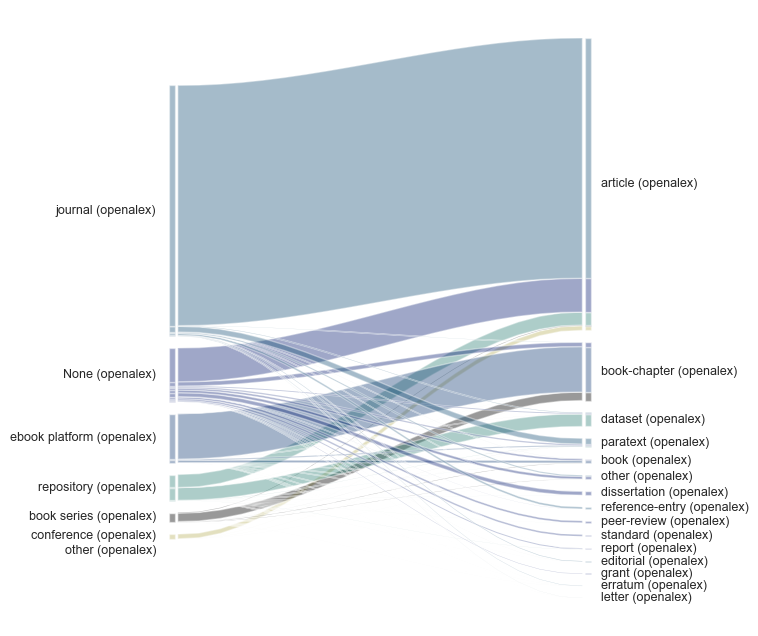

In [37]:
alluvial_plot(openalex_types_venues, 'venuetype', 'oal_type', 'openalex', 'openalex', 'oal_type_venue', 6, 8)

In [89]:
openalex_types_venues[openalex_types_venues.venuetype == 'journal']

,oal_type,venuetype,n
50,article,journal,44012387
51,book,journal,9262
52,book-chapter,journal,17105
53,dataset,journal,86747
54,dissertation,journal,996
55,editorial,journal,101479
56,erratum,journal,61707
57,letter,journal,15239
58,other,journal,205240
59,paratext,journal,1029985


In [90]:
openalex_types_venues_j = openalex_types_venues[openalex_types_venues.venuetype == 'journal'].copy()
openalex_types_venues_j['oal_new_type'] = openalex_types_venues_j.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_type']), axis=1)

In [91]:
openalex_types_venues_j

,oal_type,venuetype,n,oal_new_type
50,article,journal,44012387,research_discourse
51,book,journal,9262,None
52,book-chapter,journal,17105,None
53,dataset,journal,86747,None
54,dissertation,journal,996,None
55,editorial,journal,101479,editorial_discourse
56,erratum,journal,61707,editorial_discourse
57,letter,journal,15239,editorial_discourse
58,other,journal,205240,None
59,paratext,journal,1029985,editorial_discourse


In [72]:
s2_doctypes = client.query(f"""
                            SELECT s2_pubtypes as s2_doctype, COUNT(DISTINCT(externalids.DOI)) AS n
                            FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                            WHERE year between 2012 AND 2022
                            GROUP BY s2_pubtypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [73]:
s2_doctypes['prop'] = (s2_doctypes['n'] / s2_doctypes['n'].sum()) * 100
s2_doctypes

,s2_doctype,n,prop
0,JournalArticle,15559120,60.18787
1,Review,5667391,21.92336
2,Conference,2256584,8.72922
3,LettersAndComments,561803,2.173242
4,CaseReport,537511,2.079272
5,Study,494069,1.911224
6,Editorial,306807,1.186832
7,Book,250977,0.970863
8,ClinicalTrial,83332,0.322356
9,MetaAnalysis,69474,0.268749


In [74]:
s2_venues = client.query(f"""
                          SELECT s.type AS venuetype, COUNT(DISTINCT(externalids.DOI)) AS n
                          FROM {s2}.papers_2023_09_26 AS w
                          LEFT JOIN {s2}.venues_2023_09_26 AS s
                          ON publicationvenueid = s.id
                          WHERE year between 2012 AND 2022
                          GROUP BY venuetype
                          ORDER BY n DESC
                          """).to_dataframe()

In [75]:
s2_venues['prop'] = (s2_venues['n'] / s2_venues['n'].sum()) * 100
s2_venues

,venuetype,n,prop
0,None,32045466,56.633762
1,journal,22276524,39.369169
2,conference,2261689,3.99707


In [21]:
s2_doctypes_venues = client.query(f"""
                                  SELECT s2_pubtypes as s2_doctype, s.type AS venuetype, COUNT(DISTINCT(externalids.DOI)) AS n
                                  FROM {s2}.papers_2023_09_26 AS w, UNNEST(publicationtypes) AS s2_pubtypes
                                  LEFT JOIN {s2}.venues_2023_09_26 AS s
                                  ON publicationvenueid = s.id
                                  WHERE year between 2012 AND 2022
                                  GROUP BY venuetype, s2_doctype
                                  ORDER BY venuetype, s2_doctype
                                  """).to_dataframe()

In [22]:
s2_doctypes_venues[s2_doctypes_venues.venuetype == 'journal']

,s2_doctype,venuetype,n
24,Book,journal,2639
25,CaseReport,journal,476568
26,ClinicalTrial,journal,78147
27,Conference,journal,22373
28,Dataset,journal,548
29,Editorial,journal,274019
30,JournalArticle,journal,12040390
31,LettersAndComments,journal,524935
32,MetaAnalysis,journal,65678
33,News,journal,54973


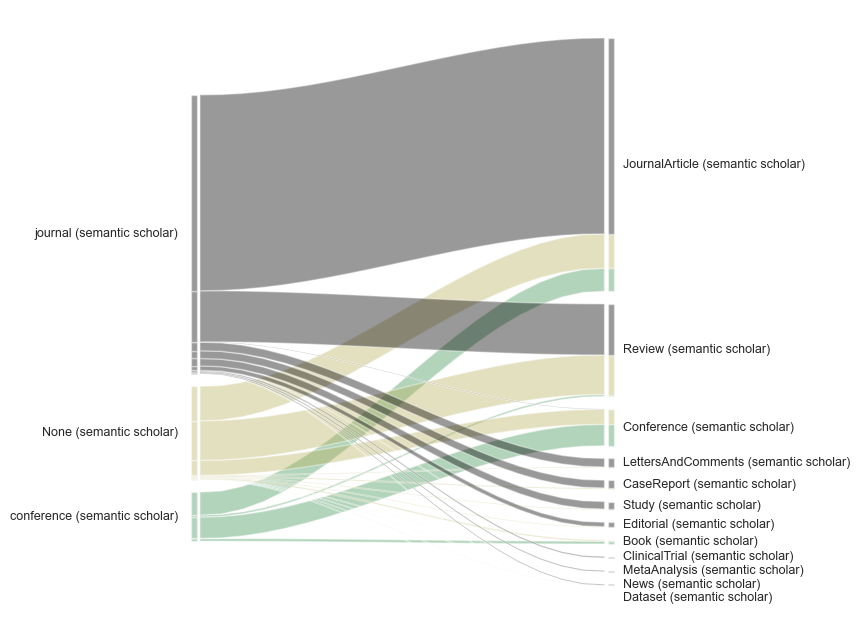

In [35]:
alluvial_plot(s2_doctypes_venues, 'venuetype', 's2_doctype', 'semantic scholar', 'semantic scholar', 's2_venue_doctype', 6, 8)

In [99]:
s2_doctypes_venues_j = s2_doctypes_venues[s2_doctypes_venues.venuetype == 'journal'].copy()
s2_doctypes_venues_j['s2_new_type'] = s2_doctypes_venues_j.apply(lambda row : mapping_types(s2_type_mapping['journal'], row['s2_doctype']), axis=1)

In [100]:
s2_doctypes_venues_j

,s2_doctype,venuetype,n,s2_new_type
24,Book,journal,2639,None
25,CaseReport,journal,476568,research_discourse
26,ClinicalTrial,journal,78147,research_discourse
27,Conference,journal,22373,None
28,Dataset,journal,548,None
29,Editorial,journal,274019,editorial_discourse
30,JournalArticle,journal,12040390,research_discourse
31,LettersAndComments,journal,524935,editorial_discourse
32,MetaAnalysis,journal,65678,research_discourse
33,News,journal,54973,editorial_discourse


In [101]:
s2_oal_doctypes = client.query(f"""
                                SELECT oal.type AS oal_doctype, s2_pubtypes as s2_doctype, 
                                       s2_sources.type AS s2_venuetype,
                                       oal_sources.type AS oal_venuetype,
                                       COUNT(DISTINCT(oal.doi)) AS n
                                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                JOIN {openalex}.works AS oal
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                    ON publicationvenueid =  s2_sources.id
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022
                                GROUP BY oal_doctype, s2_doctype, s2_venuetype, oal_venuetype
                                HAVING s2_venuetype = 'journal' AND oal_venuetype = 'journal'
                                ORDER BY oal_doctype, s2_doctype
                                """).to_dataframe()

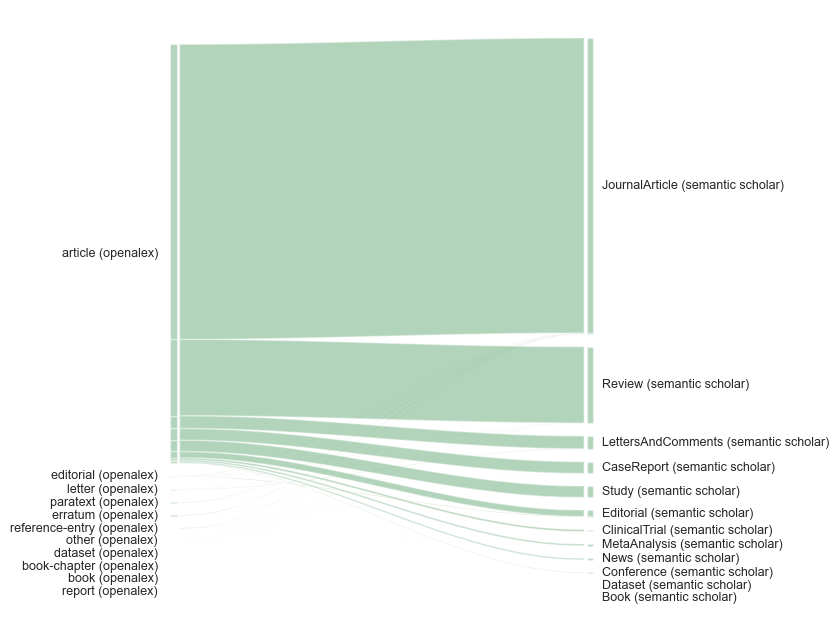

In [102]:
alluvial_plot(s2_oal_doctypes, 'oal_doctype', 's2_doctype', 'openalex', 'semantic scholar', 'openalex_s2', 6, 8)

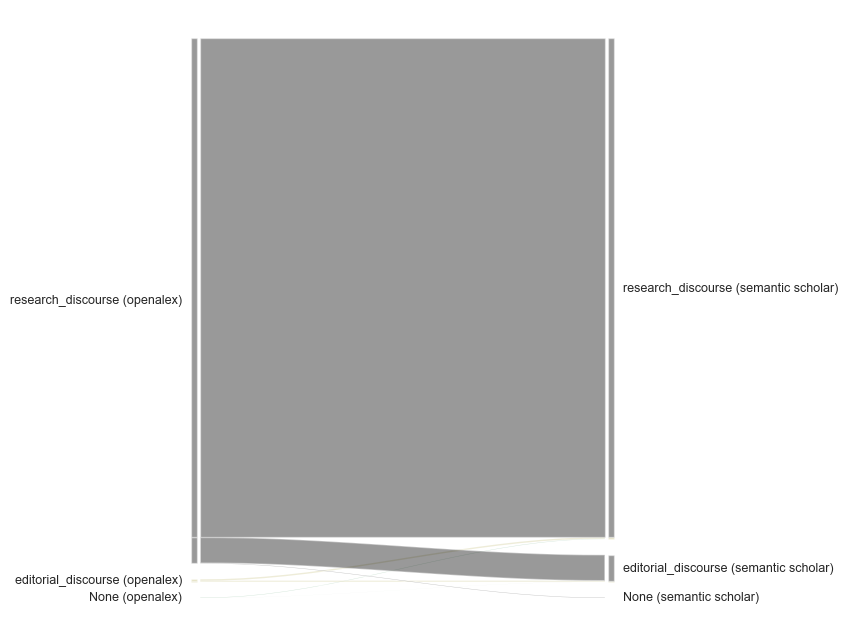

In [103]:
alluvial_plot_new_types(s2_oal_doctypes, 'oal_doctype', 's2_doctype', 'openalex', 'semantic scholar', 
                        openalex_type_mapping['journal'], s2_type_mapping['journal'], 'openalex_s2_new_clas', 6, 8)

In [104]:
s2_oal_venues = client.query(f"""
                              SELECT s2_sources.type AS s2_venuetype,
                                     oal_sources.type AS oal_venuetype,
                                     COUNT(DISTINCT(oal.doi)) AS n
                              FROM {s2}.papers_2023_09_26 AS s2
                              JOIN {openalex}.works AS oal
                                  ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                              LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                  ON publicationvenueid =  s2_sources.id
                              LEFT JOIN {openalex}.sources AS oal_sources
                                  ON primary_location.source.id = oal_sources.id
                              WHERE publication_year between 2012 AND 2022
                              GROUP BY s2_venuetype, oal_venuetype
                              ORDER BY s2_venuetype, oal_venuetype
                              """).to_dataframe()

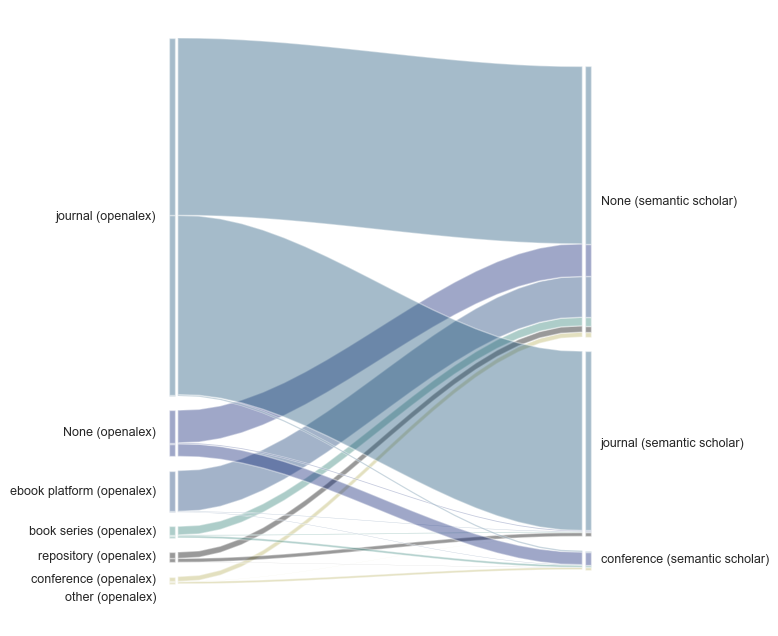

In [105]:
alluvial_plot(s2_oal_venues, 'oal_venuetype', 's2_venuetype', 'openalex', 'semantic scholar', 'openalex_s2_venues', 6, 8)

In [66]:
pm_doctypes = client.query(f"""
                            SELECT ptype AS pm_doctype, COUNT(DISTINCT(doi)) AS n
                            FROM {pm} AS pm
                            GROUP BY pm_doctype
                            ORDER BY n DESC
                            """).to_dataframe()

In [67]:
pm_doctypes['prop'] = (pm_doctypes['n'] / pm_doctypes['n'].sum()) * 100
pm_doctypes

,pm_doctype,n,prop
0,Journal Article,18041945,52.266508
1,"Research Support, Non-U.S. Gov''t",5843529,16.928378
2,Review,1970486,5.708388
3,"Research Support, N.I.H., Extramural",1352844,3.919114
4,Case Reports,1069817,3.0992
...,...,...,...
74,Periodical Index,23,0.000067
75,Legislation,21,0.000061
76,None,15,0.000043
77,Scientific Integrity Review,8,0.000023


In [110]:
oal_pm_doctypes = client.query(f"""
                                SELECT oal_works.type AS oal_doctype, ptype AS pm_doctype, COUNT(DISTINCT(oal_works.doi)) AS n,
                                FROM {pm} AS pm
                                JOIN {openalex}.works AS oal_works
                                    ON LOWER(oal_works.doi) = LOWER(pm.doi)
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022 AND oal_sources.type = 'journal'
                                GROUP BY oal_doctype, pm_doctype
                                ORDER BY oal_doctype, pm_doctype
                                """).to_dataframe()

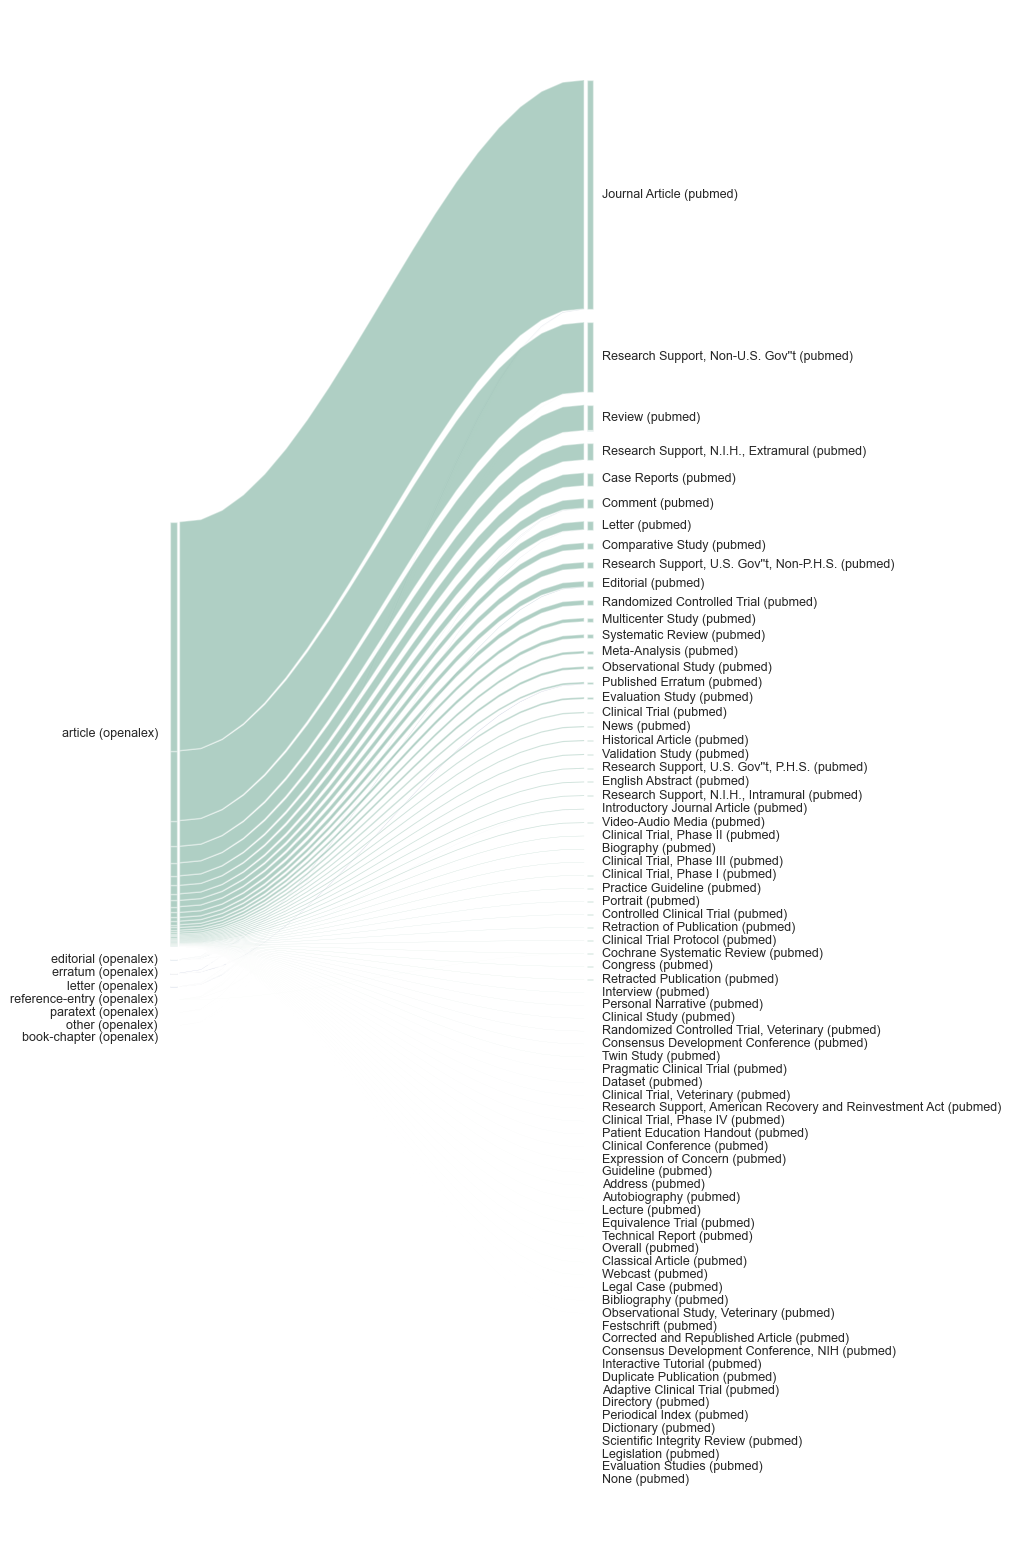

In [111]:
alluvial_plot(oal_pm_doctypes, 'oal_doctype', 'pm_doctype', 'openalex', 'pubmed', 'openalex_pubmed', 6, 20)

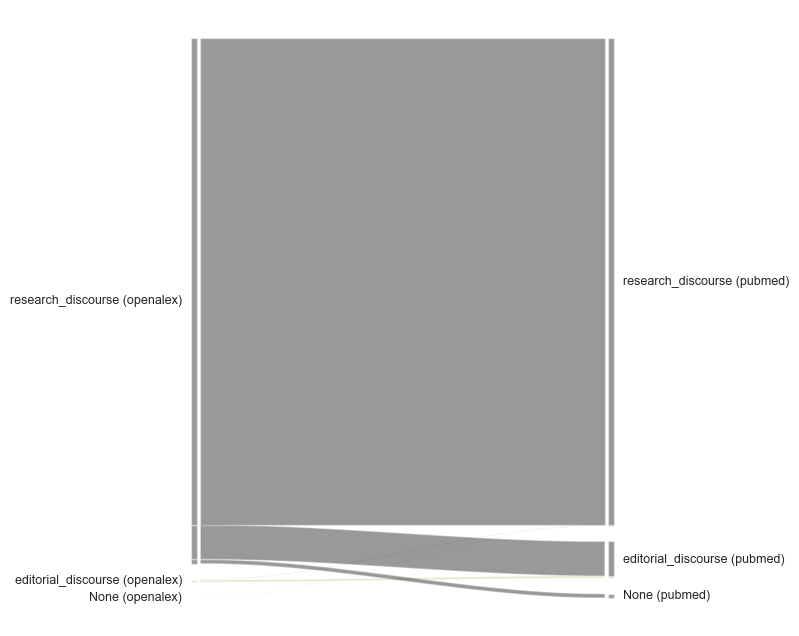

In [112]:
alluvial_plot_new_types(oal_pm_doctypes, 
                        'oal_doctype', 
                        'pm_doctype', 
                        'openalex', 
                        'pubmed', 
                        openalex_type_mapping['journal'], 
                        pubmed_type_mapping['journal'], 
                        'openalex_pubmed_new_clas', 
                        6, 
                        8)

## KB

In [48]:
oal_worktypes = pd.read_sql("""
                     SELECT type AS oal_worktype, COUNT(DISTINCT(doi)) AS n
                     FROM fiz_openalex_rep_20230819_openbib.works works
                     WHERE publication_year between 2012 AND 2022
                     GROUP BY oal_worktype
                     ORDER BY n DESC
                     """, 
                     con=engine)

In [49]:
oal_worktypes['prop'] = (oal_worktypes['n'] / oal_worktypes['n'].sum()) * 100
oal_worktypes

,oal_worktype,n,prop
0,article,51735983,74.487333
1,book-chapter,10501738,15.119969
2,dataset,2115309,3.045535
3,paratext,1430186,2.059123
4,book,877915,1.263986
5,dissertation,714665,1.028945
6,reference-entry,528947,0.761556
7,other,474053,0.682522
8,peer-review,337330,0.485674
9,standard,301094,0.433503


In [44]:
oal_venues = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, COUNT(DISTINCT(oal_works.doi)) AS number_of_dois
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype
                         ORDER BY number_of_dois DESC
                         """, 
                         con=engine)

In [46]:
oal_venues['prop'] = (oal_venues['number_of_dois'] / oal_venues['number_of_dois'].sum()) * 100
oal_venues

,oal_venuetype,number_of_dois,prop
0,journal,45221358,65.106216
1,None,9830947,14.153838
2,ebook platform,7974296,11.480775
3,repository,4194457,6.038855
4,book series,1413854,2.035558
5,conference,822713,1.184479
6,other,195,0.000281


In [24]:
oal_doctypes_venues = pd.read_sql("""
                         SELECT oal_works.type AS oal_worktype, oal_sources.type AS oal_venuetype, COUNT(DISTINCT(oal_works.doi)) AS number_of_dois
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_worktype, oal_venuetype
                         ORDER BY number_of_dois DESC
                         """, 
                         con=engine)

In [25]:
t = oal_doctypes_venues[oal_doctypes_venues.oal_venuetype == 'journal'].copy()
t['prop'] = (t['number_of_dois'] / t['number_of_dois'].sum()) * 100

oal_worktype,oal_venuetype,number_of_dois,prop
article,journal,43384203,95.937411
paratext,journal,992922,2.195692
reference-entry,journal,498743,1.102893
other,journal,133806,0.295891
editorial,journal,100140,0.221444
erratum,journal,61811,0.136685
letter,journal,15009,0.033190
book-chapter,journal,9366,0.020711
journal-volume,journal,7562,0.016722
book,journal,6545,0.014473


In [26]:
oal_doctypes_venues_j = oal_doctypes_venues[oal_doctypes_venues.oal_venuetype == 'journal'].copy()
oal_doctypes_venues_j['oal_worktype'] = oal_doctypes_venues_j.apply(lambda row : mapping_types(oal_type_mapping_kb, row['oal_worktype']), axis=1)
oal_doctypes_venues_j['oal_new_type'] = oal_doctypes_venues_j.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_worktype']), axis=1)
oal_doctypes_venues_j['oal_new_type'].fillna('None', inplace=True)
oal_doctypes_venues_j = oal_doctypes_venues_j.groupby(['oal_worktype', 'oal_venuetype', 'oal_new_type'])['number_of_dois'].sum().reset_index()
oal_doctypes_venues_j['prop'] = (oal_doctypes_venues_j['number_of_dois'] / oal_doctypes_venues_j['number_of_dois'].sum()) * 100
oal_doctypes_venues_j.sort_values(by=['prop'], ascending=False).reset_index(drop=True)

,oal_worktype,oal_venuetype,oal_new_type,number_of_dois,prop
0,article,journal,research_discourse,43394995,95.961276
1,paratext,journal,editorial_discourse,992922,2.195692
2,reference-entry,journal,None,498743,1.102893
3,other,journal,None,133806,0.295891
4,editorial,journal,editorial_discourse,100140,0.221444
5,erratum,journal,editorial_discourse,61811,0.136685
6,letter,journal,editorial_discourse,15009,0.033190
7,book-chapter,journal,None,9388,0.020760
8,book,journal,None,6755,0.014938
9,dataset,journal,None,5887,0.013018


In [50]:
scp_doctypes = pd.read_sql("""
                     SELECT unnest(item_type) AS scp_doctype, COUNT(DISTINCT(doi)) AS n
                     FROM scp_b_202307.items i
                     WHERE pubyear between 2012 AND 2022
                     GROUP BY scp_doctype
                     ORDER BY n DESC
                     """, 
                     con=engine)

In [52]:
scp_doctypes['prop'] = (scp_doctypes['n'] / scp_doctypes['n'].sum()) * 100
scp_doctypes

,scp_doctype,n,prop
0,Article,22084165,69.060948
1,Conference Paper,4534453,14.180007
2,Review,1870439,5.849182
3,Chapter,1312300,4.103786
4,Editorial,586313,1.833501
5,Note,553473,1.730804
6,Letter,500280,1.564461
7,Erratum,243428,0.761241
8,Book,167978,0.525296
9,Short Survey,98545,0.308167


In [53]:
scp_venues = pd.read_sql("""
                     SELECT source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                     FROM scp_b_202307.items i
                     WHERE pubyear between 2012 AND 2022
                     GROUP BY venuetype
                     ORDER BY n DESC
                     """, 
                     con=engine)

In [54]:
scp_venues['prop'] = (scp_venues['n'] / scp_venues['n'].sum()) * 100
scp_venues

,venuetype,n,prop
0,Journal,25910196,81.135800
1,Conference Proceeding,3599438,11.271365
2,Book Series,1231097,3.855086
3,Book,1146001,3.588615
4,Trade Journal,39325,0.123143
5,None,8291,0.025963
6,x,8,0.000025
7,Multi-volume Reference Works,1,0.000003


In [76]:
scp_doctypes_venues = pd.read_sql("""
                         SELECT unnest(item_type) AS scp_doctype, source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                         FROM scp_b_202307.items i
                         WHERE pubyear between 2012 AND 2022
                         GROUP BY venuetype, scp_doctype
                         ORDER BY n DESC
                         """, 
                         con=engine)

In [77]:
t = scp_doctypes_venues[scp_doctypes_venues.venuetype == 'Journal'].copy()
t['prop'] = (t['n'] / t['n'].sum()) * 100
t

,scp_doctype,venuetype,n,prop
0,Article,Journal,21929328,84.594741
2,Review,Journal,1849230,7.133604
5,Note,Journal,542886,2.094241
6,Editorial,Journal,503148,1.940948
7,Letter,Journal,499791,1.927998
9,Erratum,Journal,240901,0.929302
10,Conference Paper,Journal,237241,0.915183
13,Short Survey,Journal,96366,0.371742
18,Data Paper,Journal,12341,0.047607
20,Tombstone,Journal,9595,0.037014


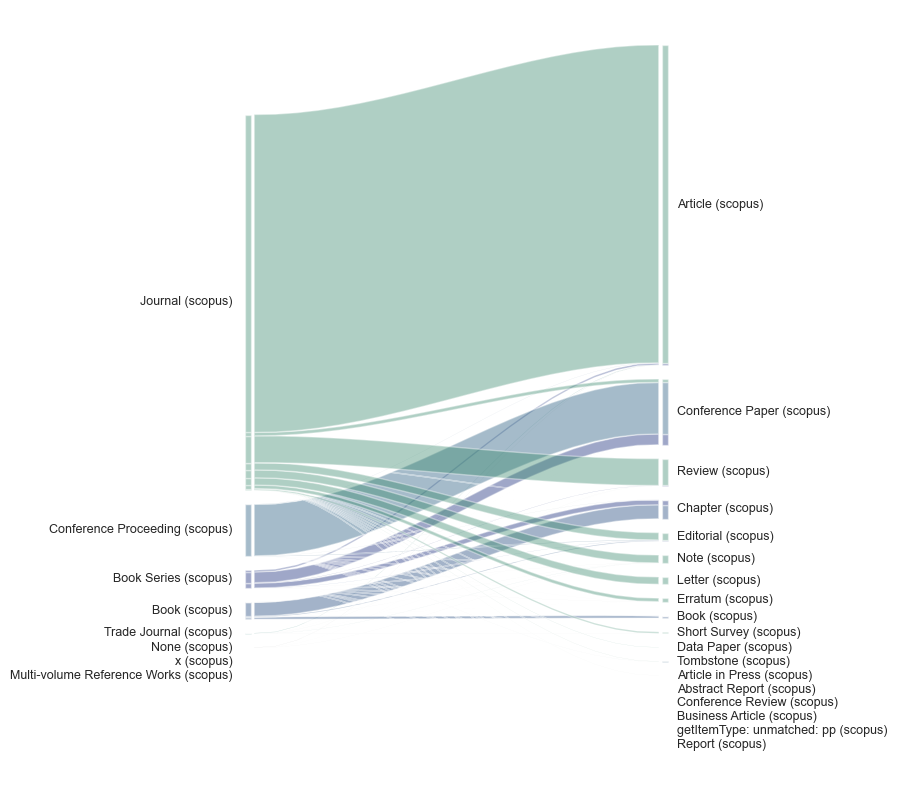

In [57]:
alluvial_plot(scp_doctypes_venues, 'venuetype', 'scp_doctype', 'scopus', 'scopus', 'scp_doctype_venue', 6, 10)

In [31]:
scp_doctypes_venues_j = scp_doctypes_venues[scp_doctypes_venues.venuetype == 'Journal'].copy()
scp_doctypes_venues_j['scp_new_type'] = scp_doctypes_venues_j.apply(lambda row : mapping_types(scp_type_mapping['journal'], row['scp_doctype']), axis=1)

In [32]:
scp_doctypes_venues_j

,scp_doctype,venuetype,n,scp_new_type
0,Article,Journal,21929328,research_discourse
2,Review,Journal,1849230,research_discourse
5,Note,Journal,542886,editorial_discourse
6,Editorial,Journal,503148,editorial_discourse
7,Letter,Journal,499791,editorial_discourse
9,Erratum,Journal,240901,editorial_discourse
10,Conference Paper,Journal,237241,None
13,Short Survey,Journal,96366,None
18,Data Paper,Journal,12341,None
20,Tombstone,Journal,9595,None


In [22]:
oal_scp_type = pd.read_sql("""
                         SELECT oal_works.type AS oal_type, unnest(item_type) AS scp_type, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND scp_items.source_type = 'Journal'
                         GROUP BY oal_type, scp_type
                         """, 
                         con=engine)

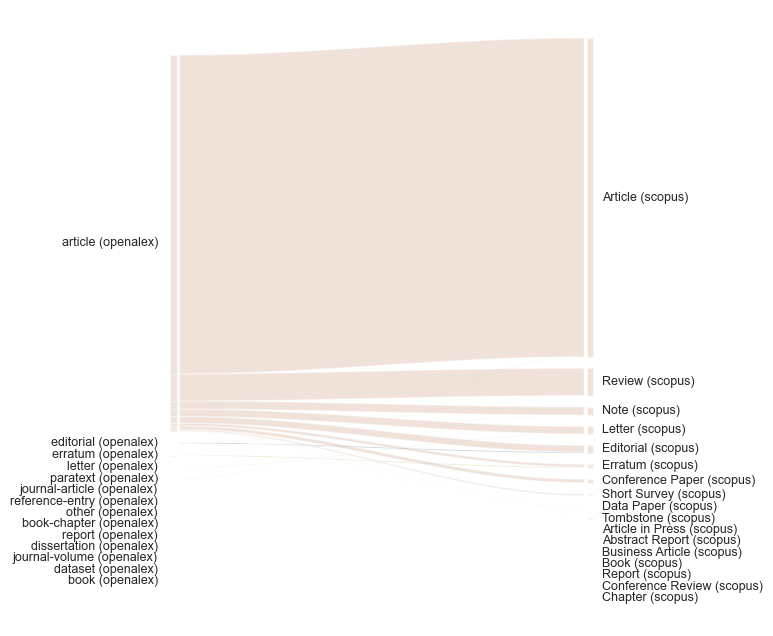

In [23]:
alluvial_plot(oal_scp_type, 'oal_type', 'scp_type', 'openalex', 'scopus', 'openalex_scp', 6, 8)

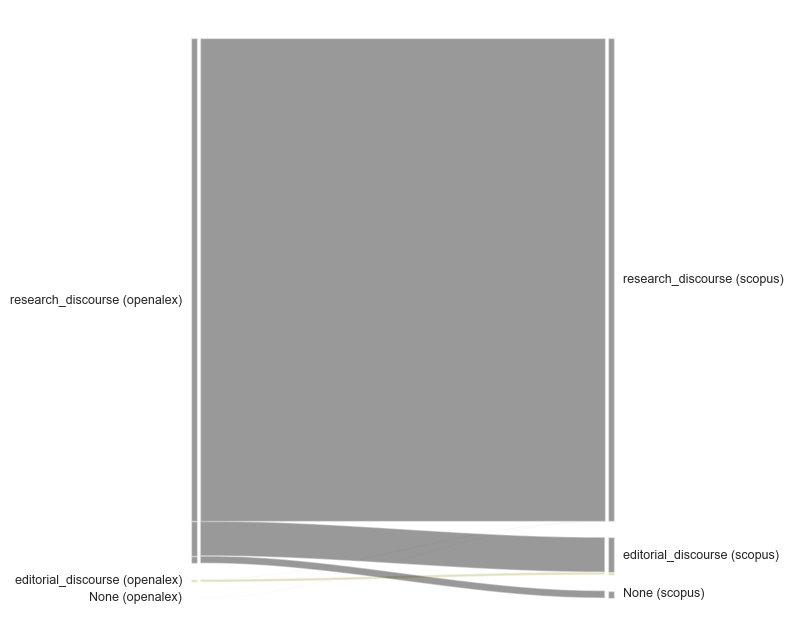

In [24]:
alluvial_plot_new_types(oal_scp_type, 'oal_type', 'scp_type', 'openalex', 'scopus', openalex_type_mapping['journal'], scp_type_mapping['journal'], 'openalex_scp_new_clas', 6, 8)

In [25]:
oal_scp_venue = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, scp_items.source_type AS scp_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, scp_venuetype
                         """, 
                         con=engine)

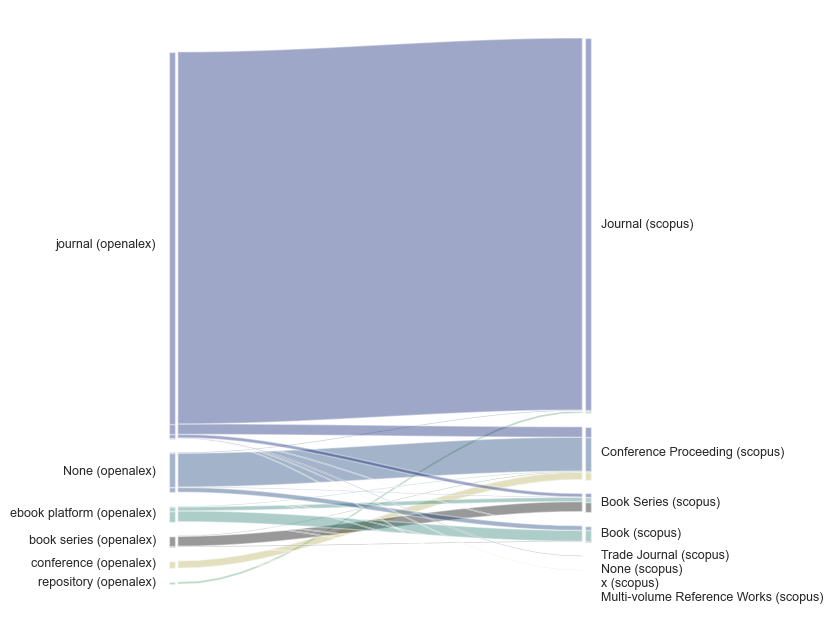

In [26]:
alluvial_plot(oal_scp_venue, 'oal_venuetype', 'scp_venuetype', 'openalex', 'scopus', 'openalex_scp_venues', 6, 8)

In [58]:
wos_doctype = pd.read_sql("""
                 SELECT unnest(item_type) AS wos_doctype, COUNT(DISTINCT(doi)) AS n
                 FROM wos_b_202307.v_items i
                 WHERE pubyear between 2012 AND 2022
                 GROUP BY wos_doctype
                 ORDER BY n DESC
                 """, 
                 con=engine)

In [59]:
wos_doctype['prop'] = (wos_doctype['n'] / wos_doctype['n'].sum()) * 100
wos_doctype

,wos_doctype,n,prop
0,Article,17614311,73.343575
1,Proceedings Paper,1920993,7.998751
2,Review,1287517,5.361044
3,Editorial Material,1007621,4.195596
4,Meeting Abstract,876455,3.649438
5,Letter,448972,1.869458
6,Book Review,345988,1.440647
7,Correction,197476,0.822263
8,Early Access,144347,0.601041
9,News Item,65320,0.271984


In [60]:
wos_venues = pd.read_sql("""
                 SELECT source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                 FROM wos_b_202307.v_items i
                 WHERE pubyear between 2012 AND 2022
                 GROUP BY venuetype
                 ORDER BY n DESC
                 """, 
                 con=engine)

In [61]:
wos_venues['prop'] = (wos_venues['n'] / wos_venues['n'].sum()) * 100
wos_venues

,venuetype,n,prop
0,Journal,21913281,93.083294
1,Book in series,1330254,5.650657
2,Book,298048,1.266049


In [40]:
wos_doctypes_venues = pd.read_sql("""
                         SELECT unnest(item_type) AS wos_doctype, source_type AS venuetype, COUNT(DISTINCT(doi)) AS n
                         FROM wos_b_202307.v_items i
                         WHERE pubyear between 2012 AND 2022
                         GROUP BY venuetype, wos_doctype
                         ORDER BY n DESC
                         """, 
                         con=engine)

In [41]:
wos_doctypes_venues[wos_doctypes_venues.venuetype == 'Journal']

,wos_doctype,venuetype,n
0,Article,Journal,17593155
2,Review,Journal,1262843
3,Editorial Material,Journal,1006883
4,Meeting Abstract,Journal,875978
5,Letter,Journal,448971
6,Book Review,Journal,345981
7,Proceedings Paper,Journal,336507
9,Correction,Journal,197383
10,Early Access,Journal,144347
11,News Item,Journal,65320


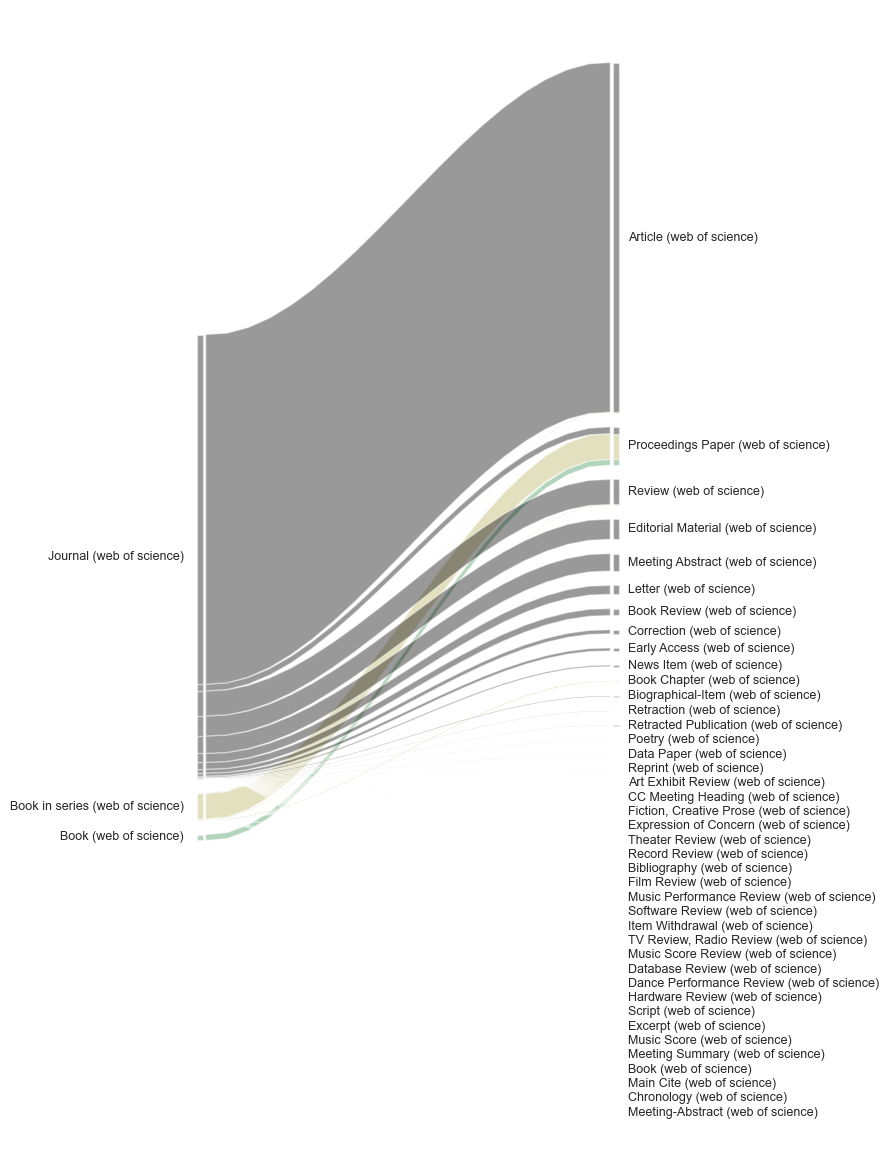

In [43]:
alluvial_plot(wos_doctypes_venues, 'venuetype', 'wos_doctype', 'web of science', 'web of science', 'wos_doctype_venue', 6, 15)

In [27]:
oal_wos_doctype = pd.read_sql("""
                         SELECT oal_works.type AS oal_doctype, unnest(item_type) AS wos_doctype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND wos_items.source_type = 'Journal'
                         GROUP BY oal_doctype, wos_doctype
                         """, 
                         con=engine)

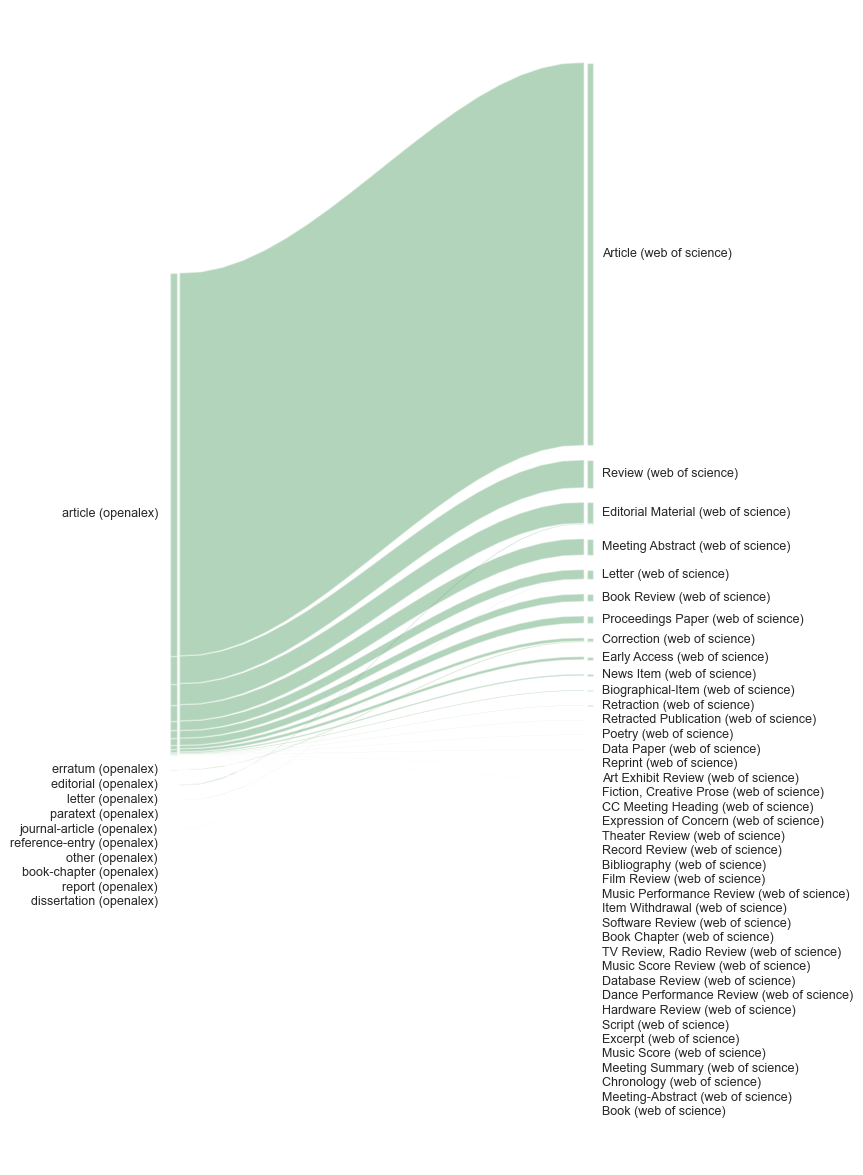

In [28]:
alluvial_plot(oal_wos_doctype, 'oal_doctype', 'wos_doctype', 'openalex', 'web of science', 'openalex_wos', 6, 15)

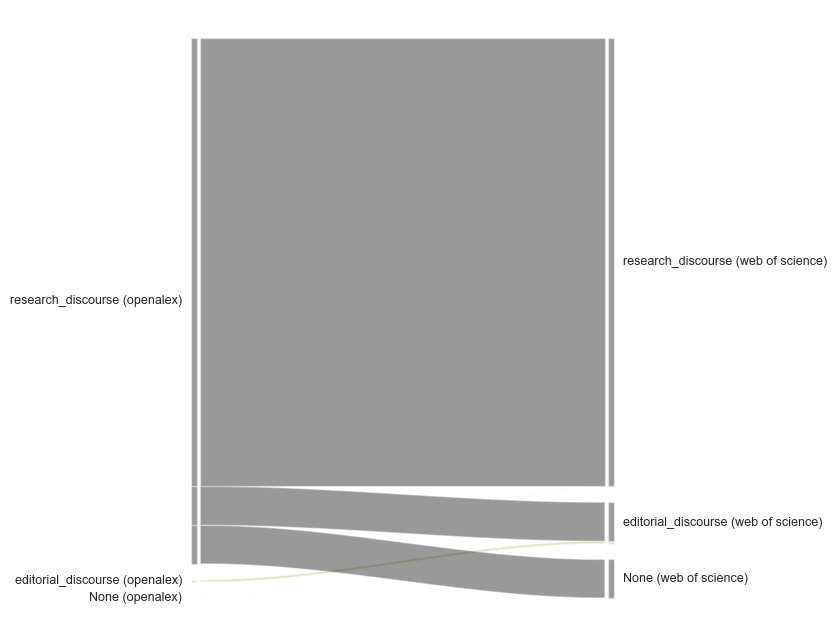

In [29]:
alluvial_plot_new_types(oal_wos_doctype, 'oal_doctype', 'wos_doctype', 'openalex', 'web of science', 
                        openalex_type_mapping['journal'], wos_type_mapping['journal'], 'openalex_wos_new_clas', 6, 8)

In [30]:
oal_wos_venue = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, wos_items.source_type AS wos_venuetype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         LEFT JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, wos_venuetype
                         """, 
                         con=engine)

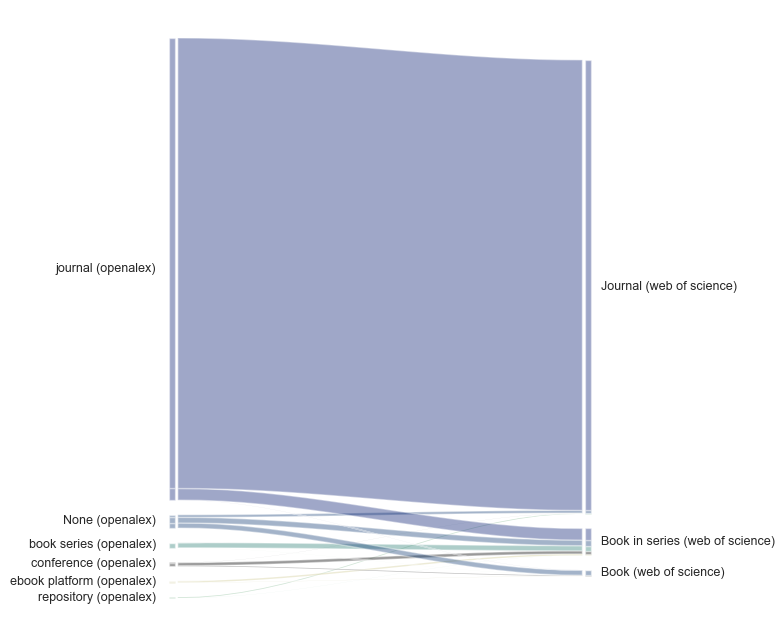

In [31]:
alluvial_plot(oal_wos_venue, 'oal_venuetype', 'wos_venuetype', 'openalex', 'web of science', 'openalex_wos_venues', 6, 8)

In [62]:
cr_doctypes = pd.read_sql("""
                          SELECT type as cr_doctype, COUNT(DISTINCT(doi)) AS n
                          FROM open_add_ons.cr_oct2023
                          WHERE issued > '2011-12-31' AND issued < '2023-01-01'
                          GROUP BY cr_doctype
                          ORDER BY n DESC
                          """, 
                          con=engine)

In [63]:
cr_doctypes['prop'] = (cr_doctypes['n'] / cr_doctypes['n'].sum()) * 100
cr_doctypes

,cr_doctype,n,prop
0,journal-article,43087439,68.730431
1,book-chapter,9505675,15.162868
2,proceedings-article,4200610,6.700555
3,dataset,1158873,1.848563
4,posted-content,1059360,1.689826
5,other,674813,1.076420
6,journal-issue,573367,0.914600
7,book,540114,0.861557
8,component,489748,0.781216
9,reference-entry,374666,0.597644


In [64]:
oal_cr_worktype = pd.read_sql("""
                         SELECT oal_works.type AS oal_worktype, cr_items.type AS cr_worktype, COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN open_add_ons.cr_oct2023 cr_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(cr_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal'
                         GROUP BY oal_worktype, cr_worktype
                         """, 
                         con=engine)

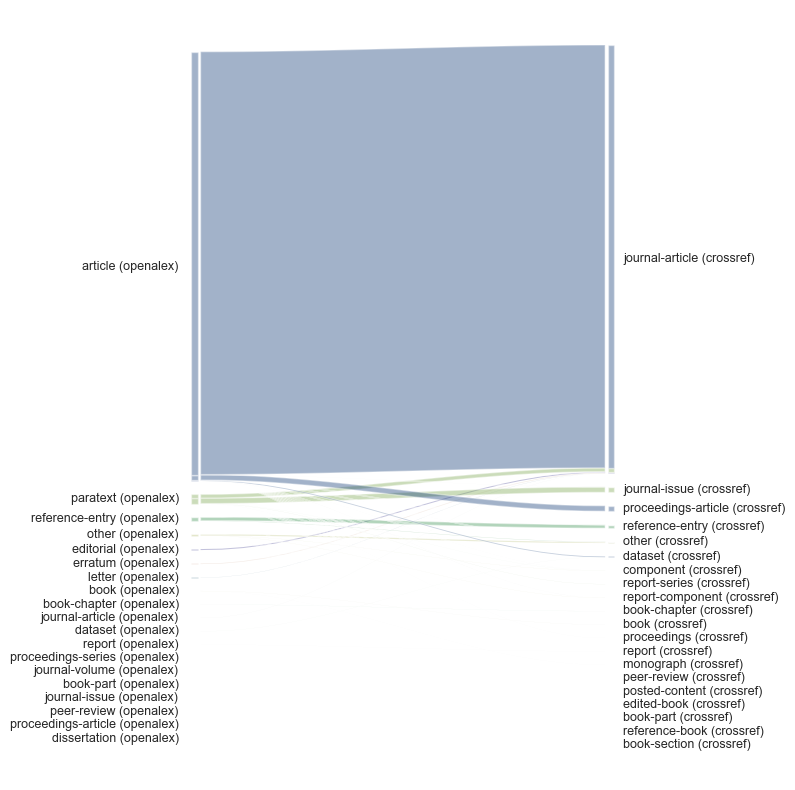

In [65]:
alluvial_plot(oal_cr_worktype, 'oal_worktype', 'cr_worktype', 'openalex', 'crossref', 'openalex_cr', 6, 10)

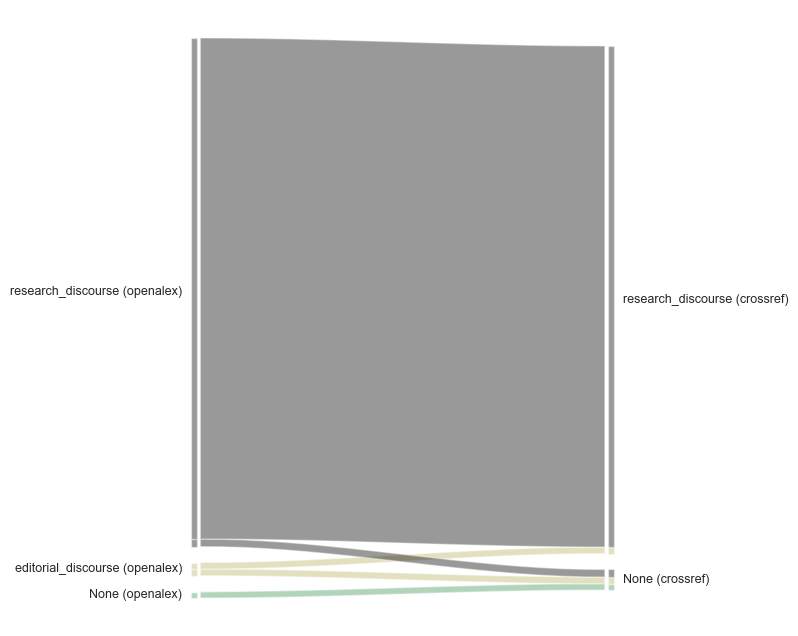

In [47]:
alluvial_plot_new_types(oal_cr_worktype, 'oal_worktype', 'cr_worktype', 'openalex', 'crossref', 
                        openalex_type_mapping['journal'], crossref_type_mapping['journal'], 'openalex_cr_new_clas', 6, 8)

In [32]:
oal_wos_scp_worktype = pd.read_sql("""
                         SELECT oal_works.type AS oal_worktype, unnest(wos_items.item_type) AS wos_worktype, unnest(scp_items.item_type) AS scp_worktype,
                             COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022 AND oal_sources.type = 'journal' AND wos_items.source_type = 'Journal'
                             AND scp_items.source_type = 'Journal'
                         GROUP BY oal_worktype, scp_worktype, wos_worktype
                         """, 
                         con=engine)

In [33]:
oal_wos_scp_worktype

,oal_worktype,wos_worktype,scp_worktype,n
0,article,Article,Abstract Report,12
1,article,Editorial Material,Abstract Report,1
2,article,Art Exhibit Review,Article,258
3,article,Article,Article,16579687
4,article,Bibliography,Article,111
...,...,...,...,...
385,reference-entry,Review,Note,6
386,reference-entry,Correction,Review,7
387,reference-entry,Review,Review,502
388,report,Article,Article,1


In [34]:
oal_wos_scp_worktype['oal_new_type'] = oal_wos_scp_worktype.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_worktype']), axis=1)
oal_wos_scp_worktype['wos_new_type'] = oal_wos_scp_worktype.apply(lambda row : mapping_types(wos_type_mapping['journal'], row['wos_worktype']), axis=1)
oal_wos_scp_worktype['scp_new_type'] = oal_wos_scp_worktype.apply(lambda row : mapping_types(scp_type_mapping['journal'], row['scp_worktype']), axis=1)

In [35]:
oal_wos_scp_worktype['oal_new_type'] = oal_wos_scp_worktype.apply(lambda row : str(row['oal_new_type']) + ' (oal)', axis=1)
oal_wos_scp_worktype['wos_new_type'] = oal_wos_scp_worktype.apply(lambda row : str(row['wos_new_type']) + ' (wos)', axis=1)
oal_wos_scp_worktype['scp_new_type'] = oal_wos_scp_worktype.apply(lambda row : str(row['scp_new_type']) + ' (scp)', axis=1)

In [36]:
oal_wos_scp_worktype['intersection'] = oal_wos_scp_worktype.apply(lambda row : str(row['oal_new_type'])+','+str(row['wos_new_type'])+','+str(row['scp_new_type']), axis=1)

In [37]:
upset_df = oal_wos_scp_worktype.groupby(['intersection'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

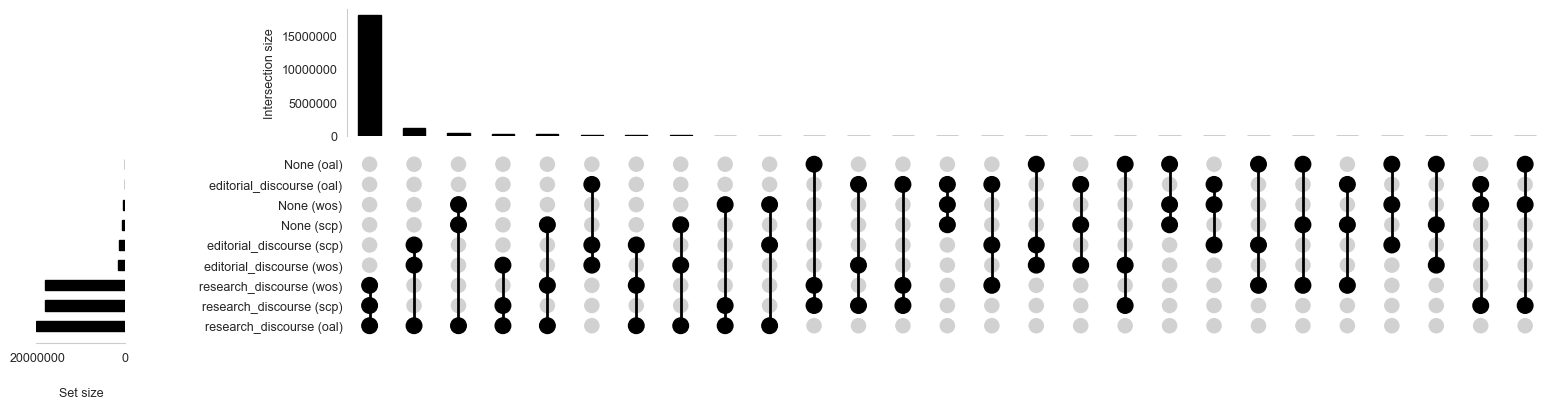

In [38]:
fig = plt.figure(figsize=(8,5))

cat_list = upset_df.intersection.tolist()
cat_list = [cat.split(',') for cat in cat_list]
n_list = upset_df.n.tolist()


upset_expr = upsetplot.from_memberships(cat_list, 
                                        data=n_list)

axes = upsetplot.UpSet(
    upset_expr,
    sort_by='cardinality',
    subset_size='sum',
    sort_categories_by='cardinality').plot(fig=fig)

axes['intersections'].yaxis.grid(False)

axes['totals'].xaxis.grid(False)

axes['intersections'].ticklabel_format(style='plain', axis='y')

axes['totals'].ticklabel_format(style='plain', axis='x')

plt.subplots_adjust(left=0, bottom=0, right=1, top=0.5, wspace=0, hspace=0)

fig.text(0.03, -0.08, 'Set size', ha='center', 
         fontdict={'fontsize': 9, 'fontweight': 500})

fig.delaxes(axes['shading'])
    
plt.show()

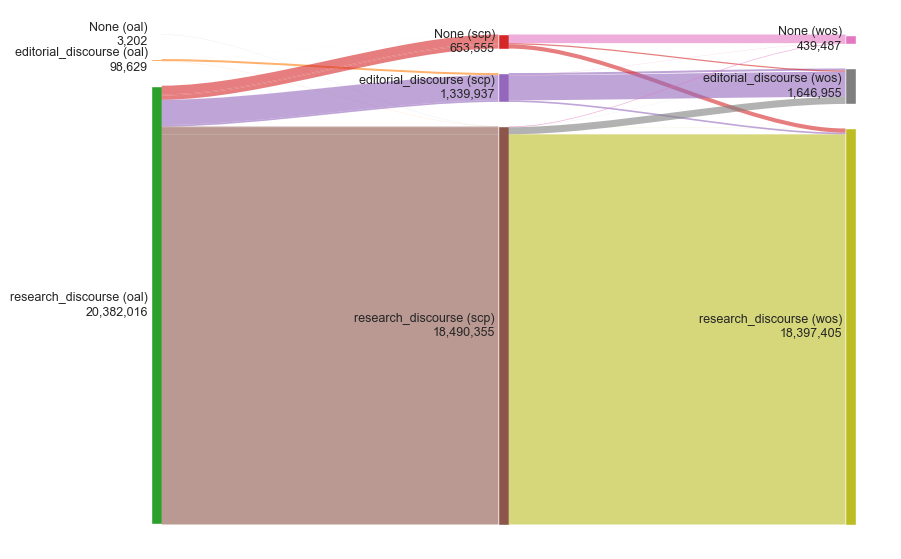

In [50]:
flows_df = oal_wos_scp_worktype[['oal_new_type', 'scp_new_type', 'wos_new_type', 'n']]
flows_df = flows_df.groupby(['oal_new_type', 'scp_new_type', 'wos_new_type'])['n'].sum().reset_index()

flows = []
for index, row in flows_df.iterrows():
    flows.append((row['oal_new_type'], row['scp_new_type'], row['n']))
    flows.append((row['scp_new_type'], row['wos_new_type'], row['n']))

plt.figure(figsize=(10, 7))

s = Sankey(flows=flows, 
           flow_color_mode='lesser', 
           node_pad_y_min=0.05, 
           node_pad_y_max=0.12,
           node_opts=dict(label_opts=dict(fontsize=9)))
s.draw()
plt.show()

In [17]:
oal_wos_scp_venuetype = pd.read_sql("""
                         SELECT oal_sources.type AS oal_venuetype, wos_items.source_type AS wos_venuetype, scp_items.source_type AS scp_venuetype,
                             COUNT(DISTINCT(oal_works.doi)) AS n
                         FROM fiz_openalex_rep_20230819_openbib.works oal_works
                         JOIN wos_b_202307.v_items wos_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(wos_items.doi)
                         JOIN scp_b_202307.items scp_items
                             ON LOWER(TRIM('https://doi.org/' FROM oal_works.doi)) = LOWER(scp_items.doi)
                         JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations oal_primary
                             ON oal_works.id = oal_primary.work_id
                         JOIN fiz_openalex_rep_20230819_openbib.sources AS oal_sources
                             ON oal_primary.source_id = oal_sources.id
                         WHERE oal_works.publication_year BETWEEN 2012 AND 2022
                         GROUP BY oal_venuetype, scp_venuetype, wos_venuetype
                         """, 
                         con=engine)

In [20]:
flows

[('book series', 'Book', 18),
 ('Book', 'Book', 18),
 ('book series', 'Book', 458),
 ('Book', 'Book in series', 458),
 ('book series', 'Book Series', 380),
 ('Book Series', 'Book', 380),
 ('book series', 'Book Series', 223909),
 ('Book Series', 'Book in series', 223909),
 ('book series', 'Book Series', 3),
 ('Book Series', 'Journal', 3),
 ('book series', 'Conference Proceeding', 76),
 ('Conference Proceeding', 'Book', 76),
 ('book series', 'Conference Proceeding', 13119),
 ('Conference Proceeding', 'Book in series', 13119),
 ('book series', 'Journal', 311),
 ('Journal', 'Book in series', 311),
 ('book series', 'Journal', 90),
 ('Journal', 'Journal', 90),
 ('book series', None, 2),
 (None, 'Book in series', 2),
 ('conference', 'Book', 36),
 ('Book', 'Book in series', 36),
 ('conference', 'Book Series', 1242),
 ('Book Series', 'Book in series', 1242),
 ('conference', 'Conference Proceeding', 33249),
 ('Conference Proceeding', 'Book', 33249),
 ('conference', 'Conference Proceeding', 14002

In [18]:
flows = []
for index, row in oal_wos_scp_venuetype.iterrows():
    flows.append((row['oal_venuetype'], row['scp_venuetype'], row['n']))
    flows.append((row['scp_venuetype'], row['wos_venuetype'], row['n']))

plt.figure(figsize=(10, 7))

s = Sankey(flows=flows, 
           flow_color_mode='lesser', 
           node_pad_y_min=0.05, 
           node_pad_y_max=0.12,
           node_opts=dict(label_opts=dict(fontsize=9)))
s.draw()
plt.show()

ValueError: Bad flow - flow is backwards: ('Book', 'Book', 18)

<Figure size 1000x700 with 0 Axes>

In [42]:
s2_oal_pm_doctypes = client.query(f"""
                                SELECT oal.type AS oal_worktype, s2_pubtypes as s2_worktype, ptype AS pm_worktype,
                                       COUNT(DISTINCT(oal.doi)) AS n
                                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                JOIN {openalex}.works AS oal
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {pm} AS pm
                                    ON LOWER(oal.doi) = LOWER(pm.doi)
                                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                    ON publicationvenueid =  s2_sources.id
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022 AND s2_sources.type = 'journal' AND oal_sources.type = 'journal'
                                GROUP BY oal_worktype, s2_worktype, pm_worktype
                                ORDER BY oal_worktype, s2_worktype, pm_worktype
                                """).to_dataframe()

In [43]:
s2_oal_pm_doctypes['oal_new_type'] = s2_oal_pm_doctypes.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['oal_worktype']), axis=1)
s2_oal_pm_doctypes['s2_new_type'] = s2_oal_pm_doctypes.apply(lambda row : mapping_types(s2_type_mapping['journal'], row['s2_worktype']), axis=1)
s2_oal_pm_doctypes['pm_new_type'] = s2_oal_pm_doctypes.apply(lambda row : mapping_types(pubmed_type_mapping['journal'], row['pm_worktype']), axis=1)

In [44]:
s2_oal_pm_doctypes['oal_new_type'] = s2_oal_pm_doctypes.apply(lambda row : str(row['oal_new_type']) + ' (oal)', axis=1)
s2_oal_pm_doctypes['s2_new_type'] = s2_oal_pm_doctypes.apply(lambda row : str(row['s2_new_type']) + ' (s2)', axis=1)
s2_oal_pm_doctypes['pm_new_type'] = s2_oal_pm_doctypes.apply(lambda row : str(row['pm_new_type']) + ' (pm)', axis=1)

In [45]:
s2_oal_pm_doctypes['intersection'] = s2_oal_pm_doctypes.apply(lambda row : str(row['oal_new_type'])+','+str(row['s2_new_type'])+','+str(row['pm_new_type']), axis=1)
upset_df = s2_oal_pm_doctypes.groupby(['intersection'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

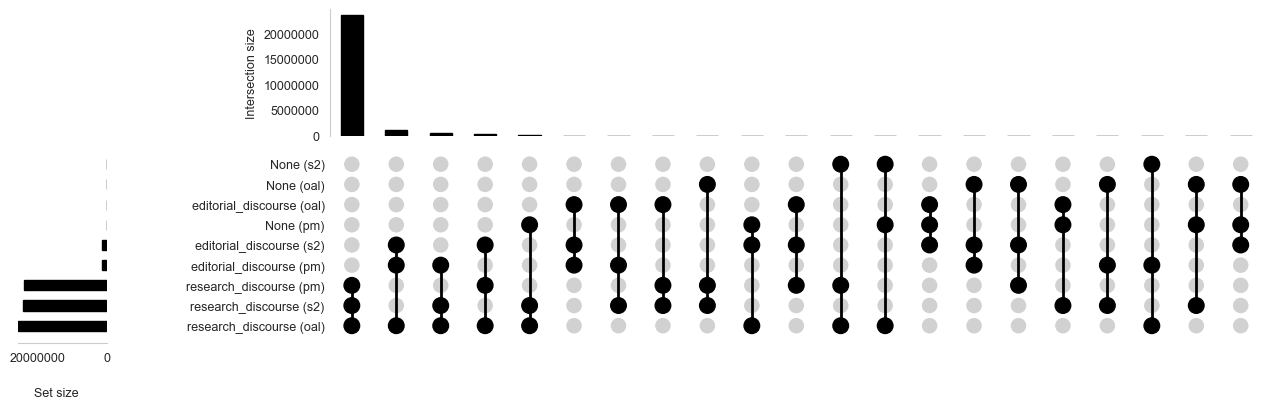

In [46]:
fig = plt.figure(figsize=(8,5))

cat_list = upset_df.intersection.tolist()
cat_list = [cat.split(',') for cat in cat_list]
n_list = upset_df.n.tolist()


upset_expr = upsetplot.from_memberships(cat_list, 
                                        data=n_list)

axes = upsetplot.UpSet(
    upset_expr,
    sort_by='cardinality',
    subset_size='sum',
    sort_categories_by='cardinality').plot(fig=fig)

axes['intersections'].yaxis.grid(False)

axes['totals'].xaxis.grid(False)

axes['intersections'].ticklabel_format(style='plain', axis='y')

axes['totals'].ticklabel_format(style='plain', axis='x')

plt.subplots_adjust(left=0, bottom=0, right=1, top=0.5, wspace=0, hspace=0)

fig.text(0.03, -0.08, 'Set size', ha='center', 
         fontdict={'fontsize': 9, 'fontweight': 500})

fig.delaxes(axes['shading'])
    
plt.show()

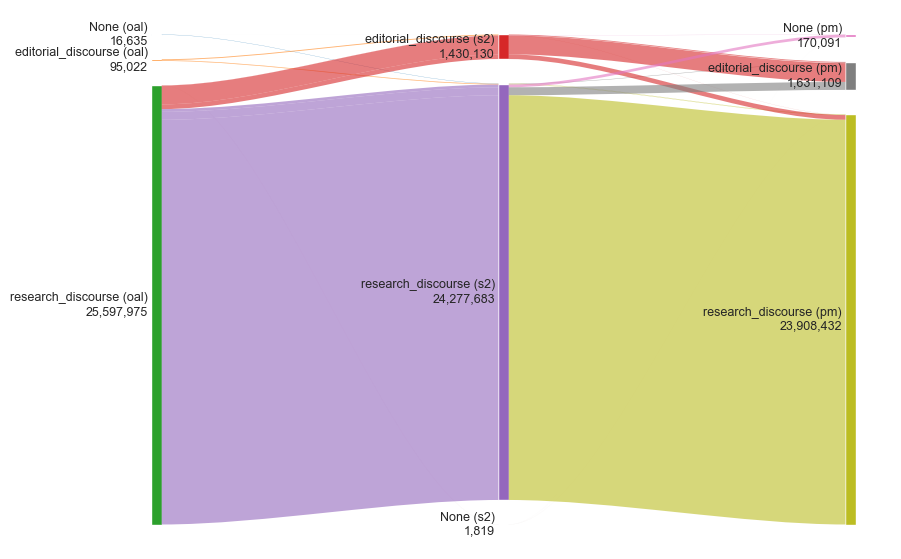

In [51]:
flows_df = s2_oal_pm_doctypes[['oal_new_type', 's2_new_type', 'pm_new_type', 'n']]
flows_df = flows_df.groupby(['oal_new_type', 's2_new_type', 'pm_new_type'])['n'].sum().reset_index()

flows = []
for index, row in flows_df.iterrows():
    flows.append((row['oal_new_type'], row['s2_new_type'], row['n']))
    flows.append((row['s2_new_type'], row['pm_new_type'], row['n']))

plt.figure(figsize=(10, 7))

s = Sankey(flows=flows, 
           flow_color_mode='lesser', 
           node_pad_y_min=0.05, 
           node_pad_y_max=0.12,
           node_opts=dict(label_opts=dict(fontsize=9)))
s.draw()
plt.show()

In [30]:
type_characteristics_df = client.query(f"""
                                          SELECT AVG(number_of_authors) AS avg_number_of_authors,
                                                 AVG(number_of_citations) AS avg_number_of_citations,
                                                 AVG(page_count) AS avg_page_count,
                                                 AVG(number_of_references) AS avg_number_of_references,
                                                 AVG(has_abstract) AS avg_has_abstract,
                                                 AVG(has_oa) AS avg_has_oa,
                                                 type
                                          FROM (
                                          SELECT COUNT(DISTINCT(oal_aut.author.id)) AS number_of_authors, 
                                                 oal.cited_by_count AS number_of_citations, 
                                                 ABS(CAST(REGEXP_EXTRACT(biblio.last_page, r'\d+') AS INT64) - CAST(REGEXP_EXTRACT(biblio.first_page, r'\d+') AS INT64)) AS page_count, 
                                                 ARRAY_LENGTH(referenced_works) AS number_of_references, 
                                                 CASE 
                                                     WHEN cr.abstract IS NOT NULL THEN 1
                                                     ELSE 0
                                                 END AS has_abstract,
                                                 CASE 
                                                     WHEN open_access.is_oa = True THEN 1
                                                     ELSE 0
                                                 END AS has_oa,
                                                 CASE 
                                                     WHEN ptype IN ('Cochrane Systematic Review', 'Systematic Review', 'Meta-Analysis', 'Review', 'Case Reports', 'Randomized Controlled Trial', 'Clinical Trial', 
                               'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                               'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article', 'Comparative Study', 'Multicenter Study', 
                               'Observational Study', 'Evaluation Study', 'Historical Article', 'Validation Study', 'Clinical Study', 'Randomized Controlled Trial, Veterinary',
                               'Twin Study', 'Clinical Trial, Veterinary', 'Classical Article', 'Observational Study, Veterinary', 'Corrected and Republished Article', 
                               'Adaptive Clinical Trial', 'Evaluation Studies', 'Validation Studies', "Research Support, Non-U.S. Gov''t", "Research Support, N.I.H., Extramural", 
                               "Research Support, U.S. Gov''t, Non-P.H.S.", "Research Support, U.S. Gov''t, P.H.S.",
                               "Research Support, N.I.H., Intramural", "Research Support, American Recovery and Reinvestment Act") THEN 'research_discourse'
                                                     WHEN ptype in ('Published Erratum', 'Retraction of Publication', 'Retracted Publication', 'Editorial', 'News', 'Letter', 'Comment',
                                'Introductory Journal Article', 'Newspaper Article') THEN 'editorial_discourse'
                                                     ELSE NULL
                                                END AS type
                                          FROM {openalex}.works AS oal, UNNEST(authorships) AS oal_aut 
                                          JOIN {pm} AS pm
                                              ON LOWER(oal.doi) = LOWER(pm.doi) 
                                          LEFT JOIN {cr} AS cr
                                              ON LOWER(pm.doi) = LOWER(cr.doi)
                                          WHERE publication_year between 2012 AND 2022 
                                          GROUP BY number_of_citations, number_of_references, has_abstract, has_oa, page_count, type
                                        )
                                        GROUP BY type
                                      """).to_dataframe()

In [31]:
type_characteristics_df

,avg_number_of_authors,avg_number_of_citations,avg_page_count,avg_number_of_references,avg_has_abstract,avg_has_oa,type
0,59.990379,102.770965,11740.516334,79.615585,0.375867,0.587960,research_discourse
1,59.575843,44.617365,20.761010,27.246672,0.262566,0.650984,editorial_discourse
2,16.980016,56.507133,41.139373,44.726810,0.294544,0.588601,None


In [166]:
oal_classifier_sample_1 = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal_aut.author.id)) AS number_of_authors, 
                                             oal.cited_by_count AS number_of_citations, 
                                             ABS(CAST(REGEXP_EXTRACT(biblio.last_page, r'\d+') AS INT64) - CAST(REGEXP_EXTRACT(biblio.first_page, r'\d+') AS INT64)) AS page_count, 
                                             ARRAY_LENGTH(referenced_works) AS number_of_references, 
                                             CASE 
                                                 WHEN cr.abstract IS NOT NULL THEN 1
                                                 ELSE 0
                                             END AS has_abstract,
                                             ptype AS type
                                      FROM {openalex}.works AS oal, UNNEST(authorships) AS oal_aut 
                                      JOIN {pm} AS pm
                                          ON LOWER(oal.doi) = LOWER(pm.doi) 
                                      LEFT JOIN {cr} AS cr
                                          ON LOWER(pm.doi) = LOWER(cr.doi)
                                      WHERE publication_year between 2012 AND 2022 
                                          AND ptype NOT IN ('Systematic Review', 'Meta-Analysis', 'Review', 'Case Reports', 'Randomized Controlled Trial', 'Clinical Trial', 
                                                           'Clinical Trial, Phase II', 'Clinical Trial, Phase III', 'Clinical Trial, Phase I', 
                                                           'Clinical Trial, Phase IV', 'Controlled Clinical Trial', 'Pragmatic Clinical Trial', 'Journal Article')
                                      GROUP BY  number_of_citations, page_count, number_of_references, has_abstract, type
                                      ORDER BY RAND()
                                      LIMIT 50000
                                      """).to_dataframe()

In [167]:
oal_classifier_sample_2 = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal_aut.author.id)) AS number_of_authors, 
                                             oal.cited_by_count AS number_of_citations, 
                                             ABS(CAST(REGEXP_EXTRACT(biblio.last_page, r'\d+') AS INT64) - CAST(REGEXP_EXTRACT(biblio.first_page, r'\d+') AS INT64)) AS page_count, 
                                             ARRAY_LENGTH(referenced_works) AS number_of_references, 
                                             CASE 
                                                 WHEN cr.abstract IS NOT NULL THEN 1
                                                 ELSE 0
                                             END AS has_abstract,
                                             ptype AS type
                                      FROM {openalex}.works AS oal, UNNEST(authorships) AS oal_aut 
                                      JOIN {pm} AS pm
                                          ON LOWER(oal.doi) = LOWER(pm.doi) 
                                      LEFT JOIN {cr} AS cr
                                          ON LOWER(pm.doi) = LOWER(cr.doi)
                                      WHERE publication_year between 2012 AND 2022
                                      GROUP BY  number_of_citations, page_count, number_of_references, has_abstract, type
                                      ORDER BY RAND()
                                      LIMIT 50000
                                      """).to_dataframe()

In [168]:
df_sample = pd.concat([oal_classifier_sample_1, oal_classifier_sample_2], ignore_index=True)

In [169]:
df_sample['new_type'] = df_sample.apply(lambda row : mapping_types(pubmed_type_mapping['journal'], row['type']), axis=1)
df_sample.drop(columns=['type'], inplace=True)
df_sample.dropna(inplace=True)

In [170]:
df_sample

,number_of_authors,number_of_citations,page_count,number_of_references,has_abstract,new_type
0,9,16,21,241,1,research_discourse
1,54,3,16,60,0,research_discourse
2,11,213,5,32,0,research_discourse
3,9,30,10,56,0,research_discourse
5,13,68,14,60,0,research_discourse
...,...,...,...,...,...,...
99995,5,29,26,124,0,research_discourse
99996,30,172,0,46,0,editorial_discourse
99997,10,9,4,6,0,research_discourse
99998,12,17,10,21,0,research_discourse


In [252]:
# https://medium.com/analytics-vidhya/building-classification-model-with-python-9bdfc13faa4b
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

feature = df_sample.drop('new_type', axis=1)

# Select Target
target = df_sample['new_type']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.4, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, pos_label='research_discourse')
    rec = metrics.recall_score(y_test, y_pred, pos_label='research_discourse')
    f1 = metrics.f1_score(y_test, y_pred, pos_label='research_discourse')
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba, pos_label='research_discourse')
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

# Evaluate Model
dtc_eval = evaluate_model(neigh, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Shape of training feature: (52259, 5)
Shape of testing feature: (34840, 5)
Shape of training label: (52259,)
Shape of training label: (34840,)
Accuracy: 0.9540183696900115
Precision: 0.9673989661654135
Recall: 0.9852826802273407
F1 Score: 0.9762589288360651
Cohens Kappa Score: 0.25066457011577215
Area Under Curve: 0.7453335327550105
Confusion Matrix:
 [[  300  1110]
 [  492 32938]]


In [172]:
df_sample[df_sample.new_type == 'editorial_discourse']

,number_of_authors,number_of_citations,page_count,number_of_references,has_abstract,new_type
6,36,0,0,28,1,editorial_discourse
12,43,5,2,30,0,editorial_discourse
14,3,0,6,19,0,editorial_discourse
61,2,12,3,43,0,editorial_discourse
80,9,6,6,36,0,editorial_discourse
...,...,...,...,...,...,...
99933,1,8,2,10,1,editorial_discourse
99942,4,11,7,32,1,editorial_discourse
99989,1,59,2,7,0,editorial_discourse
99996,30,172,0,46,0,editorial_discourse


In [173]:
oal_classifier_sample_3 = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal_aut.author.id)) AS number_of_authors, 
                                             oal.cited_by_count AS number_of_citations, 
                                             ABS(CAST(REGEXP_EXTRACT(biblio.last_page, r'\d+') AS INT64) - CAST(REGEXP_EXTRACT(biblio.first_page, r'\d+') AS INT64)) AS page_count, 
                                             ARRAY_LENGTH(referenced_works) AS number_of_references, 
                                             CASE 
                                                 WHEN cr.abstract IS NOT NULL THEN 1
                                                 ELSE 0
                                             END AS has_abstract,
                                             ptype AS type
                                      FROM {openalex}.works AS oal, UNNEST(authorships) AS oal_aut 
                                      JOIN {pm} AS pm
                                          ON LOWER(oal.doi) = LOWER(pm.doi) 
                                      LEFT JOIN {cr} AS cr
                                          ON LOWER(pm.doi) = LOWER(cr.doi)
                                      WHERE publication_year between 2012 AND 2022
                                      GROUP BY  number_of_citations, page_count, number_of_references, has_abstract, type
                                      ORDER BY RAND()
                                      LIMIT 2000
                                      """).to_dataframe()

In [174]:
oal_classifier_sample_3['new_type'] = oal_classifier_sample_3.apply(lambda row : mapping_types(pubmed_type_mapping['journal'], row['type']), axis=1)
oal_classifier_sample_3.drop(columns=['type'], inplace=True)
oal_classifier_sample_3.dropna(inplace=True)

In [175]:
oal_classifier_sample_3.reset_index(drop=True, inplace=True)

In [253]:
sample3 = oal_classifier_sample_3.copy()
features = sample3.drop('new_type', axis=1)

classifierresults = neigh.predict(features)
sample3['test_results'] = classifierresults

In [254]:
testarray = sample3[['test_results']].to_numpy()
origarray = sample3[['new_type']].to_numpy()
pr_metrics = sklearn.metrics.classification_report(origarray, testarray)


In [255]:
print(pr_metrics)

                     precision    recall  f1-score   support

editorial_discourse       0.42      0.22      0.29        49
 research_discourse       0.98      0.99      0.98      1715

           accuracy                           0.97      1764
          macro avg       0.70      0.61      0.64      1764
       weighted avg       0.96      0.97      0.97      1764

